2021.07.05 臭氧預警 複迴歸方法

1. 讀取sample data(2018~2020，全年度)
    - 北: 新店、板橋、古亭
    - 中: 南投、竹山、埔里
    - 南: 屏東、潮州、小港
2. 變數(y=O3八小每日最大值)
    - x=O3小時值每日最大值 + 當日0點CO小時值(OR 當日0\~7點CO累積值 OR 當日0\~3 vs 5~7點CO提升比率)
    - (ex:南投站) x=O3小時值每日最大值 + 彰化、線西、沙鹿、大里站的O3小時值、O3前3小時平均?
    - (未來)+光化測站資料
3. Model (單變數v.s.多元線性迴歸)
    - sklearn.linear_model
    - 當年度 與 下年度驗證
4. 分鐘值 與 小時值
    - 疊圖比較 

In [24]:
import pandas as pd
import numpy as np  

# from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics

import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.CsvEngn import *

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

import datetime
import math

# EDA

## 讀檔

In [2]:
bak_file_path = r"G:\我的雲端硬碟\python\output\0705\AQI_rowdata_20210705_11.21.18.pkl"
df = read_data_dir_fPathExt(bak_file_path)
# df.head()

  >> 讀取:: G:\我的雲端硬碟\python\output\0705\AQI_rowdata_20210705_11.21.18.pkl


In [3]:
# 新增 光化變數與溫度
add_file_path = r"G:\我的雲端硬碟\python\output\0709\光化變數與溫度_2018to2021_06_20210709_18.29.03.pkl"
df_add = read_data_dir_fPathExt(add_file_path)

df_add.rename(columns={"MonitorDate":"DataCreationDate"}, inplace=True)

  >> 讀取:: G:\我的雲端硬碟\python\output\0709\光化變數與溫度_2018to2021_06_20210709_18.29.03.pkl


In [4]:
print(len(df))
# 合併
df = df.merge(df_add, how="left", on=["SiteName","DataCreationDate"])
print(len(df))

3522511
3522511


In [5]:
# 篩選測站 & 篩選年分
site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里", "屏東","潮州","小港"]
year_min_max = [2018,2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year>=year_min_max[0]) & (df["DataCreationDate"].dt.year<=year_min_max[1])
df_pic = df[pic_mask].reset_index(drop=True)
df_pic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244152 entries, 0 to 244151
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             244152 non-null  int64         
 1   SiteName          244152 non-null  object        
 2   County            244152 non-null  object        
 3   AQI               240758 non-null  float64       
 4   Pollutant         129506 non-null  object        
 5   Status            243914 non-null  object        
 6   SO2               237985 non-null  float64       
 7   CO                239670 non-null  float64       
 8   O3                239046 non-null  float64       
 9   O3_8hr            241872 non-null  float64       
 10  PM10              237085 non-null  float64       
 11  PM2.5             233989 non-null  float64       
 12  NO2               236667 non-null  float64       
 13  NOx               236668 non-null  float64       
 14  NO  

In [6]:
# 移除遺漏值
df_pic.dropna(subset=["O3_8hr", "O3"], inplace=True)

In [7]:
# 合併 冷熱季 欄位


## 變數

In [7]:
#定義實際超標門檻值
exceed_value_real = 71 #實際超標門檻值(臭氧橘警71)
df_pic.loc[:,"O3_8hr_max"] = df_pic.loc[:,["SiteName","date","O3_8hr"]].groupby(by=["SiteName","date"]).transform(max).values
df_pic.loc[:,"is_exceed_date"] = df_pic.loc[:,"O3_8hr_max"] >= exceed_value_real

# 抓出超標時間點，合併回df_pic
df_pic_real_exceed_time = df_pic[df_pic["O3_8hr"]>=exceed_value_real][["SiteName","date","DataCreationDate"]].groupby(
                                                            ["SiteName","date"], as_index=False).min()
df_pic_real_exceed_time.loc[:,"real_exceed_hour"] = df_pic_real_exceed_time.loc[:,"DataCreationDate"].dt.hour
df_pic = df_pic.merge(df_pic_real_exceed_time[["SiteName","date","real_exceed_hour"]], how="left", on=["SiteName","date"])

In [8]:
# 計算每日O3_8hr、O3最大值
cols = ["O3_8hr","O3"]
gp_cols = ["SiteName","date"]
df_daily_max = df_pic[gp_cols+cols].groupby(by=gp_cols, as_index=False).max()
df_daily_max.rename(columns={"O3_8hr":"O3_8hr_max", "O3":"O3_max"}, inplace=True)

In [10]:
df_daily_max["date"].nunique()

1094

In [11]:
# # 檢查 (跳過 移除遺漏值 步驟)
# mask = (df_daily_max["SiteName"].isin(["南投"])) & (df_daily_max["date"].apply(lambda d: d.year == 2019)) & ((pd.isna(df_daily_max["O3_max"])))
# formtoXlsx(df_daily_max[mask].reset_index(drop=True), "2019年_南投測站_O3全天都缺值日期")

In [12]:
# 相關性
df_daily_max.corr(method ='pearson')

,O3_8hr_max,O3_max
O3_8hr_max,1.000000,0.939707
O3_max,0.939707,1.000000


In [13]:
# df_result
df_result = df_daily_max.copy(deep=True)

### 監測因子相關

#### 每日7~12點 提升量(gradian)

In [14]:
objectGradian_lst = ["O3","CO", "NOx","NO","NO2","SO2"]

In [15]:
time_start = 7
time_end = 12

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0、7點 小時值
mask_start = (df_pic["DataCreationDate"].dt.hour==time_start)
mask_end = (df_pic["DataCreationDate"].dt.hour==time_end)

# 計算差值、百分比 gradian
for obj in objectGradian_lst:
    df_gradian = df_pic.loc[mask_start, ["SiteName","date", obj]].merge(
                        df_pic.loc[mask_end, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_gradian.rename(columns={f"{obj}_x":f"{obj}_at{time_start}", f"{obj}_y":f"{obj}_at{time_end}"}, inplace=True)
    
#     計算
    df_gradian.loc[:,f"{obj}_gradian_diff_{time_start}to{time_end}"] = df_gradian.loc[:,f"{obj}_at{time_end}"] - df_gradian.loc[:,f"{obj}_at{time_start}"]
#     df_gradian.loc[:,f"{obj}_gradian_ratio"] = (df_gradian.loc[:,f"{obj}_gradian_diff"] / df_gradian.loc[:,f"{obj}_at{time_end}"])*100
#     去除重複 (因取兩個時間點，在串資料時會*2)
    df_gradian.drop_duplicates(keep="first", inplace=True)
    df_result = df_result.merge(df_gradian[["SiteName","date",f"{obj}_gradian_diff_{time_start}to{time_end}"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,O3_gradian_diff_7to12,CO_gradian_diff_7to12,NOx_gradian_diff_7to12,NO_gradian_diff_7to12,NO2_gradian_diff_7to12,SO2_gradian_diff_7to12
0,南投,2018-01-01,45.0,58.0,22.0,0.0,0.0,3.0,-2.0,1.0
1,南投,2018-01-02,41.0,54.0,38.0,0.0,-6.0,-12.0,6.0,3.0
2,南投,2018-01-03,53.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN
3,南投,2018-01-04,30.0,45.0,32.0,0.0,-4.0,-6.0,3.0,2.0
4,南投,2018-01-05,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# 整合成 df_pic4
df_pic_4 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238667 entries, 0 to 238666
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   index                   238667 non-null  int64         
 1   SiteName                238667 non-null  object        
 2   County                  238667 non-null  object        
 3   AQI                     237189 non-null  float64       
 4   Pollutant               127659 non-null  object        
 5   Status                  238667 non-null  object        
 6   SO2                     235984 non-null  float64       
 7   CO                      237436 non-null  float64       
 8   O3                      238667 non-null  float64       
 9   O3_8hr                  238667 non-null  float64       
 10  PM10                    234747 non-null  float64       
 11  PM2.5                   231601 non-null  float64       
 12  NO2                     234718

O3_8hr_max                1.000000
O3_gradian_diff_7to12     0.688322
CO_gradian_diff_7to12    -0.046524
NOx_gradian_diff_7to12   -0.236128
NO_gradian_diff_7to12    -0.159044
NO2_gradian_diff_7to12   -0.225948
SO2_gradian_diff_7to12    0.109203
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

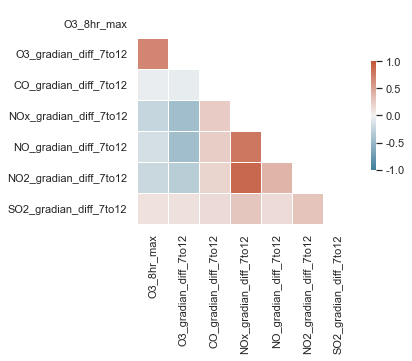

In [17]:
# 相關性 每日gradian 相關性太低 
corr = df_result.drop(columns=["O3_max"]).corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

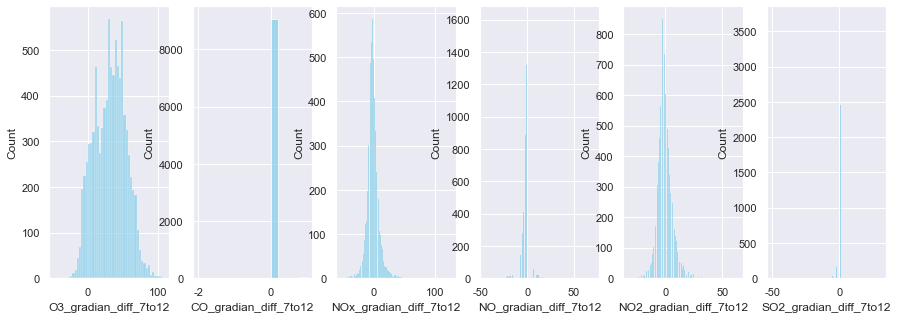

In [18]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectGradian_lst), figsize=(15, 5))

for idx, col in enumerate(objectGradian_lst):
    sns.histplot(data=df_result, x=f"{col}_gradian_diff_{time_start}to{time_end}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

>可嘗試以 **沙鹿測站**作為**南投測站**的有效上風測站(先行指標)

#### 每日小時值 最大值

In [14]:
objectMax_lst = ["CO", "NOx","NO","NO2","SO2", "AMB_TEMP", "CH4", "NMHC", "THC"]

In [15]:

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 計算每日小時值 最大值
gp_cols = ["SiteName","date"]
df_daily_max_others = df_pic[gp_cols+objectMax_lst].groupby(by=gp_cols, as_index=False).max()
for col in objectMax_lst:
    df_daily_max_others.rename(columns={col:f"{col}_max"}, inplace=True)
    df_result = df_result.merge(df_daily_max_others[["SiteName","date",f"{col}_max"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,CO_max,NOx_max,NO_max,NO2_max,SO2_max,AMB_TEMP_max,CH4_max,NMHC_max,THC_max
0,南投,2018-01-01,45.0,58.0,0.0,35.0,10.0,32.0,3.0,25.0,1.0,0.0,2.0
1,南投,2018-01-02,41.0,54.0,1.0,54.0,38.0,41.0,8.0,26.0,2.0,0.0,2.0
2,南投,2018-01-03,53.0,79.0,1.0,45.0,4.0,42.0,7.0,25.0,2.0,0.0,2.0
3,南投,2018-01-04,30.0,45.0,0.0,55.0,25.0,42.0,5.0,22.0,2.0,0.0,2.0
4,南投,2018-01-05,7.0,15.0,0.0,54.0,28.0,33.0,4.0,22.0,1.0,0.0,2.0


In [16]:
# 整合成 df_pic5
df_pic_5 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238619 entries, 0 to 238618
Data columns (total 43 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             238619 non-null  int64         
 1   SiteName          238619 non-null  object        
 2   County            238619 non-null  object        
 3   AQI               237141 non-null  float64       
 4   Pollutant         127619 non-null  object        
 5   Status            238619 non-null  object        
 6   SO2               235936 non-null  float64       
 7   CO                237389 non-null  float64       
 8   O3                238619 non-null  float64       
 9   O3_8hr            238619 non-null  float64       
 10  PM10              234699 non-null  float64       
 11  PM2.5             231553 non-null  float64       
 12  NO2               234670 non-null  float64       
 13  NOx               234670 non-null  float64       
 14  NO  

O3_8hr_max      1.000000
O3_max          0.939707
CO_max         -0.089034
NOx_max        -0.099744
NO_max         -0.201802
NO2_max         0.040839
SO2_max         0.063399
AMB_TEMP_max    0.145002
CH4_max         0.222926
NMHC_max       -0.033101
THC_max         0.130411
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

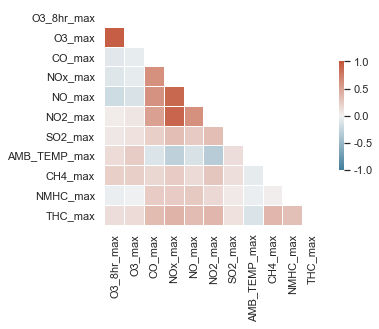

In [17]:
# 相關性 每日MAX 相關性太低 除了O3 MAX
corr = df_result.corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

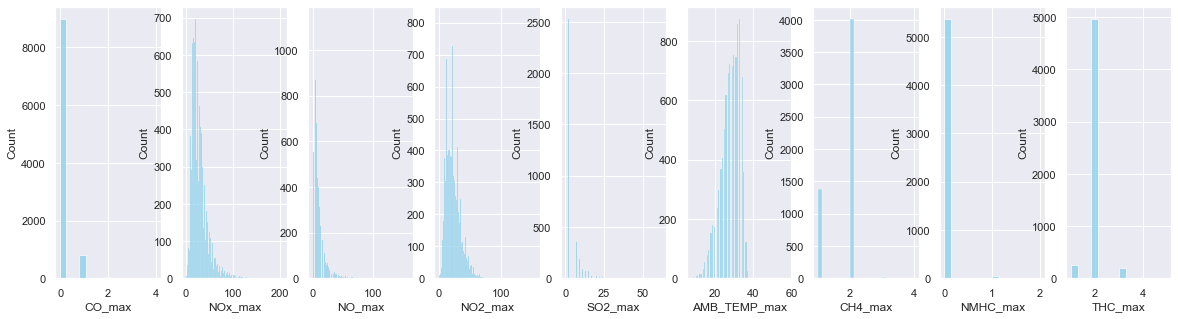

In [18]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectMax_lst), figsize=(20, 5))

for idx, col in enumerate(objectMax_lst):
    sns.histplot(data=df_result, x=f"{col}_max", kde=False, color="skyblue", ax=axs[idx])

plt.show()

# Model

以2018年建模(train)、2019年驗證(test)

## (原)單變數迴歸



*******南投*******

>> Mean Absolute Error: 3.465419793767522
>> Root Mean Squared Error: 4.648017067238402



*******南投 當年度驗證*******

*******南投*******

>>預測目標門檻值: 71

>> TN: 353
>> FP: 1
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.2

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
4.0    1
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 330
>> FP: 1
>> FN: 11
>> TP: 11

>> 預警成功率: 0.5
>> 假警報率: 0.083

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
13    3
15    3
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    5
3.0    4
4.0    2
dtype: int64


*******古亭*******

>> Mean Absolute Error: 5.227502988475138
>> Root Mean Squared Error: 6.597801194145728



*******古亭 當年度驗證*******

*******古亭*******

>>預測目標門檻值: 71

>> TN: 334
>> FP: 8
>> FN: 12
>> TP: 10

>> 預警成功率: 0.455
>> 假警報率: 0.444

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
12    3
14    2
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0   

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 65307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 38928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 36317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Gl

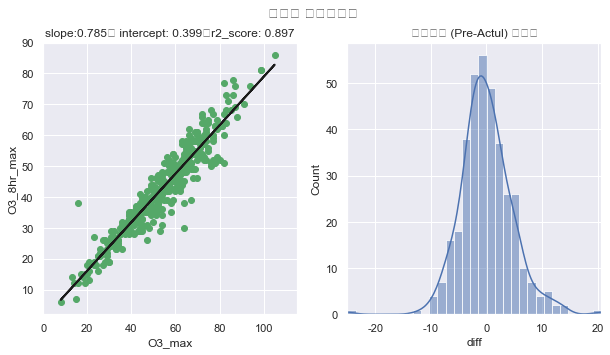

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 21476 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 20141 missing from current font.
  font.set_text(s, 0, flags=flags)


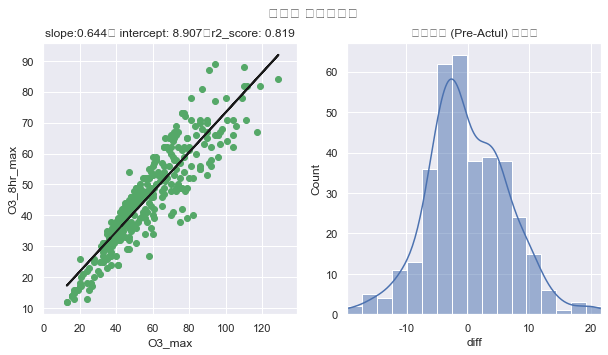

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 28207 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 28207 missing from current font.
  font.set_text(s, 0, flags=flags)


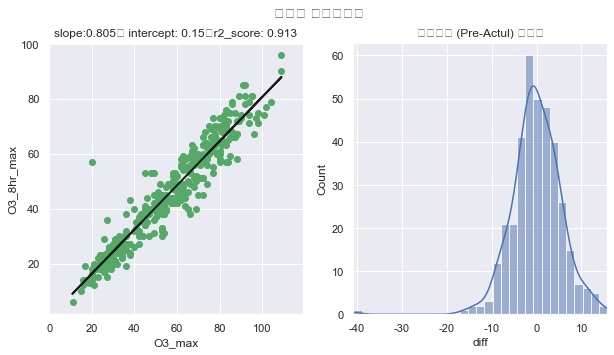

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 23631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 23631 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)


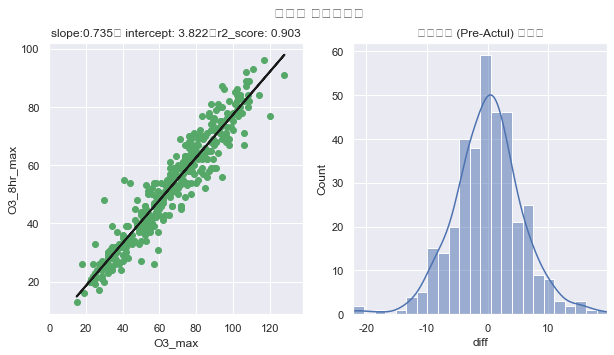

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 27211 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 26495 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 27211 missing from current font.
  font.set_text(s, 0, flags=flags)


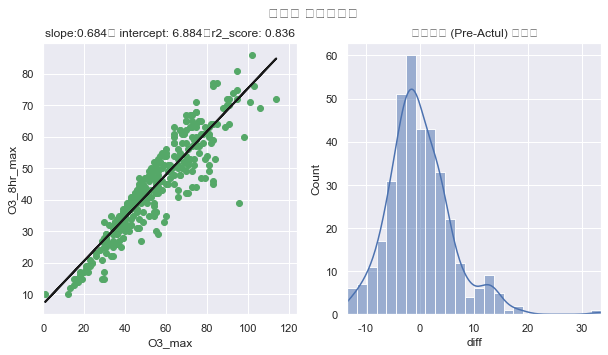

In [22]:
for s in df_result["SiteName"].unique():
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train]['O3_max'].values.reshape(-1,1) 
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic[mask_test_self]['O3'].values.reshape(-1,1) 
    y_test_self = df_pic[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic[mask_test_next]['O3'].values.reshape(-1,1) 
    y_test_next = df_pic[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Plot outputs
    fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
    fig.suptitle(f'{s}站 單變數迴歸\n\n\n')
    
    axes[0].scatter(X_train, y_train,  color='g')
    axes[0].plot(X_train, y_train_pred, color='k', linewidth=2)
    axes[0].set_xlim(0, X_train.max()+10)
    axes[0].set_xlabel('O3_max')
    axes[0].set_ylabel('O3_8hr_max')
    axes[0].set_title(f"slope:{round(reg.coef_[0][0],3)}； intercept: {round(reg.intercept_[0],3)}；r2_score: {round(r2_score(y_train, y_train_pred),3)}")
    
    # diff hist()
    single_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    single_reg_diff.loc[:, "diff"] = single_reg_diff.loc[: ,"Predicted"] - single_reg_diff.loc[: ,"Actual"]
    sns.histplot(data=single_reg_diff, x="diff", kde=True, ax=axes[1])
    axes[1].set_xlim(single_reg_diff.loc[:, "diff"].min(), single_reg_diff.loc[:, "diff"].max())
    axes[1].set_title(f"預測差距 (Pre-Actul) 直方圖")
    
    print(f"\n\n*******{s}*******\n")
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print("\n\n")

    # 當年度驗證 self
    print(f"*******{s} 當年度驗證*******\n")


    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")


    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f"*******{s}*******\n")

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")


    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")


    # 下年度驗證 next
    print(f"*******{s} 下年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

## 複迴歸測試

### 參數設定(+O3_gradian_diff_7to12)

In [25]:
# 變數設定
X_col_model = ['O3_max',"O3_gradian_diff_7to12"]
X_col_test = ['O3',"O3_gradian_diff_7to12"]
df_pic_for_model = df_pic_4.copy(deep=True)

In [26]:
# 刪除遺漏值
df_result.dropna(how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test, how='any'))}")
df_pic_for_model.dropna(subset=X_col_test, how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 11399


Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'AMB_TEMP', 'CH4', 'NMHC', 'THC', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'O3_gradian_diff_7to12', 'CO_gradian_diff_7to12',
       'NOx_gradian_diff_7to12', 'NO_gradian_diff_7to12',
       'NO2_gradian_diff_7to12', 'SO2_gradian_diff_7to12'],
      dtype='object')



*******南投*******

>> X:['O3_max', 'O3_gradian_diff_7to12']
>> slope:[[0.69352921 0.11493844]]
>> intercept: 1.548
>> r2_score: 0.905

>> Mean Absolute Error: 3.3951601647948815
>> Root Mean Squared Error: 4.461839900600448


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 334
>> FP: 0
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.0

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
4.0    1
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 316
>> FP: 1
>> FN: 10
>> TP: 10

>> 預警成功率: 0.5
>> 假警報率: 0.091

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
13    3
12    2
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    5
4.0    3
2.0    2
dtype: int64


*******古亭*******

>> X:['O3_max', 'O3_gradian_diff_7to12']
>> slope:[[ 0.79540024 -0.17062072]]
>> intercept: 4.801
>> r2_score: 0.86

>> Mean Absolute Error: 4.3776681484190085
>> Root Mean Squared Error: 5.8561776878992


*******古亭 當年度驗證*******

>>預測目標門檻值: 71


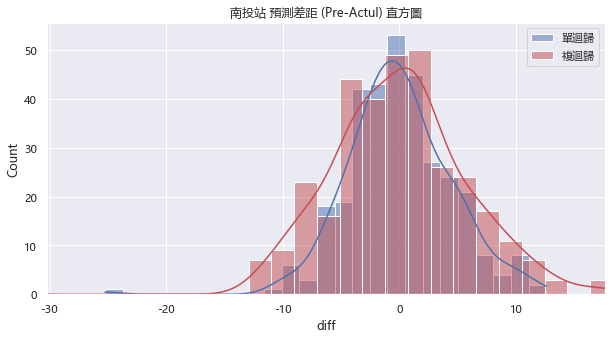

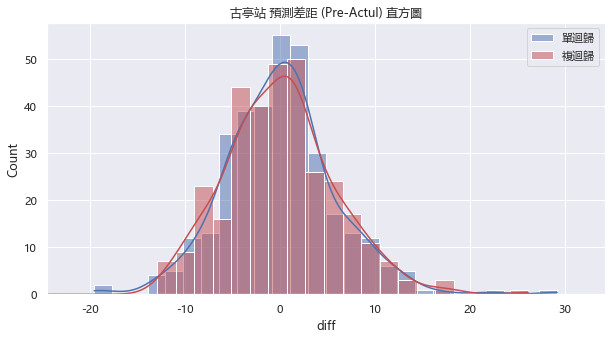

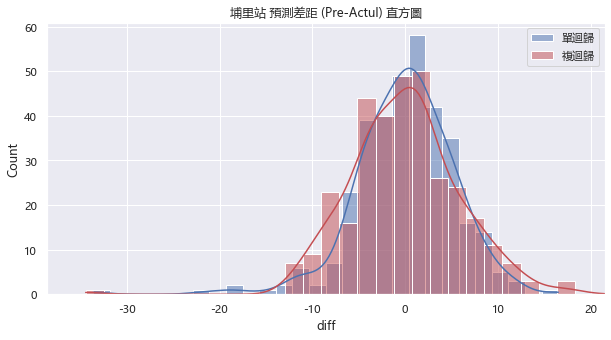

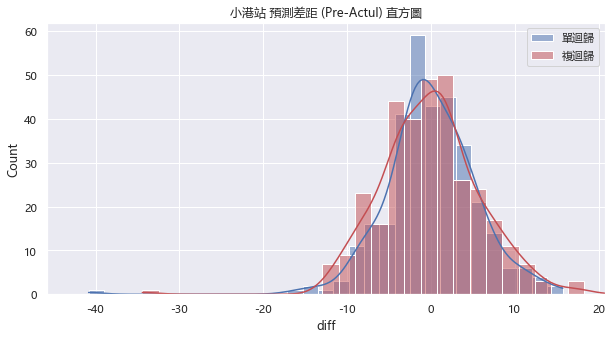

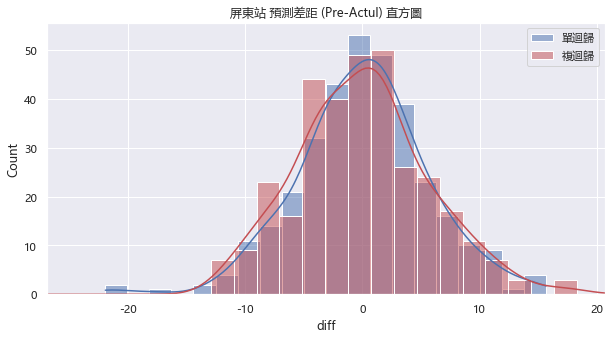

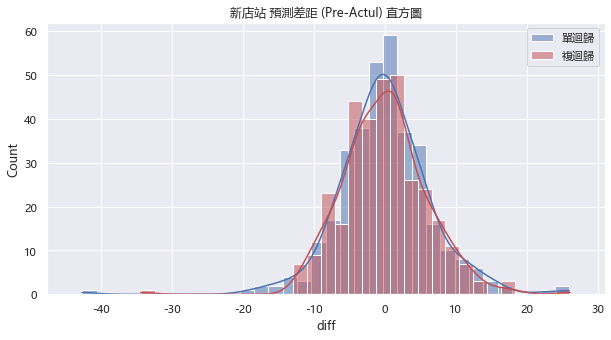

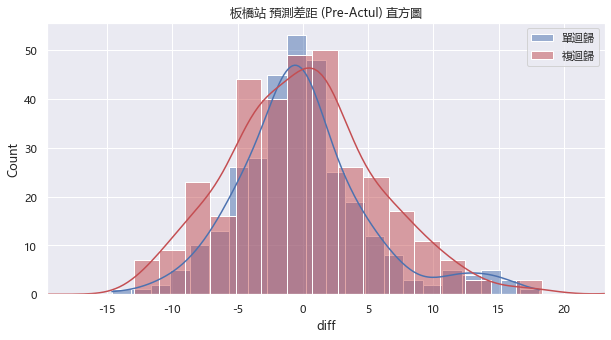

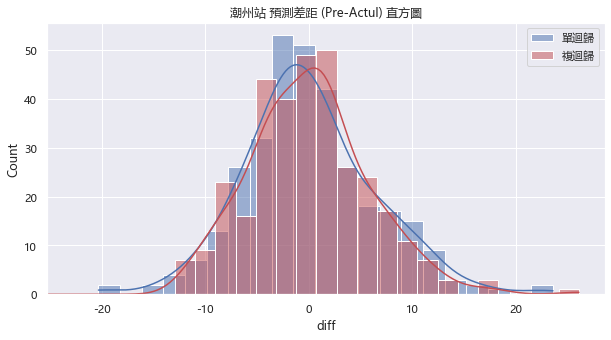

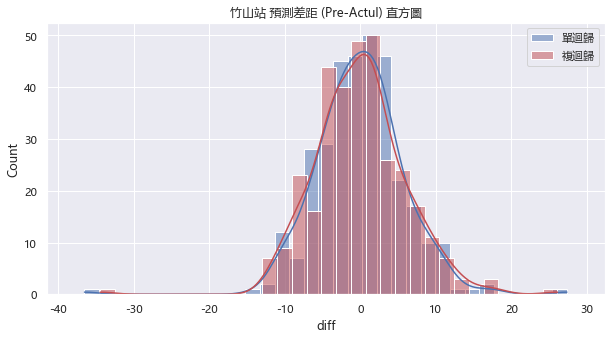

In [27]:
for s in df_result["SiteName"].unique():
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Print outputs
    print(f"\n\n*******{s}*******\n")
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([mutil_reg_diff, single_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

### 參數設定(+溫度)

In [19]:
# 變數設定
X_col_model = ['O3_max',"AMB_TEMP_max"]
X_col_test = ['O3',"AMB_TEMP"]
df_pic_for_model = df_pic_5.copy(deep=True)

In [20]:
# 刪除遺漏值
df_result.dropna(how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test, how='any'))}")
df_pic_for_model.dropna(subset=X_col_test, how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 1145


Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'AMB_TEMP', 'CH4', 'NMHC', 'THC', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'CO_max', 'NOx_max', 'NO_max', 'NO2_max', 'SO2_max',
       'AMB_TEMP_max', 'CH4_max', 'NMHC_max', 'THC_max'],
      dtype='object')



*******南投*******

>> X:['O3_max', 'AMB_TEMP_max']
>> slope:[[0.77614225 0.09938346]]
>> intercept: -1.99
>> r2_score: 0.898

>> Mean Absolute Error: 3.4396865276353643
>> Root Mean Squared Error: 4.62721158655901


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 353
>> FP: 1
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.2

>> 預警成功 發布時間點 統計:
時間點   次數
14    4
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
4.0    1
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 330
>> FP: 1
>> FN: 12
>> TP: 10

>> 預警成功率: 0.455
>> 假警報率: 0.091

>> 預警成功 發布時間點 統計:
時間點   次數
13    3
14    3
15    3
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    4
2.0    3
4.0    2
1.0    1
dtype: int64


*******古亭*******

>> X:['O3_max', 'AMB_TEMP_max']
>> slope:[[ 0.68245164 -0.34033909]]
>> intercept: 15.937
>> r2_score: 0.836

>> Mean Absolute Error: 4.810503389310303
>> Root Mean Squared Error: 6.278969374223636


*******古亭 當年度驗證*******

>>預測目標門檻值: 71

>> T

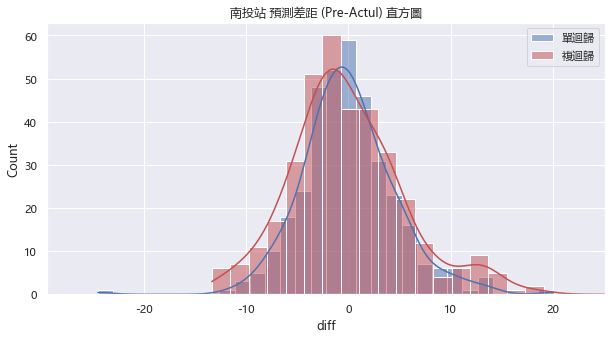

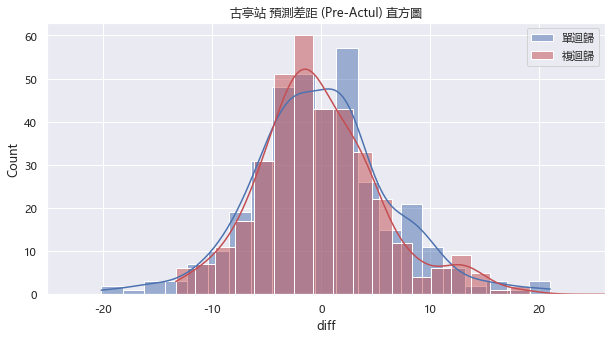

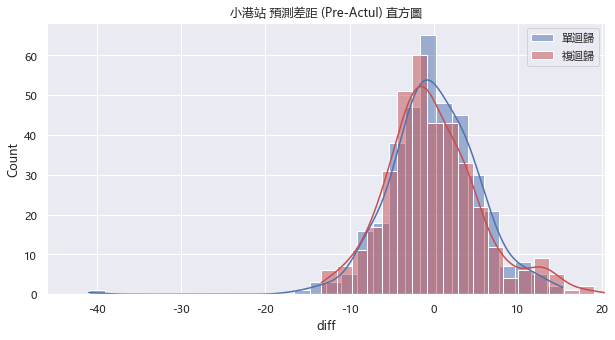

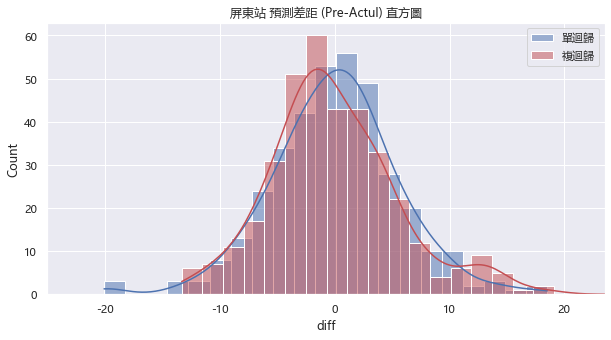

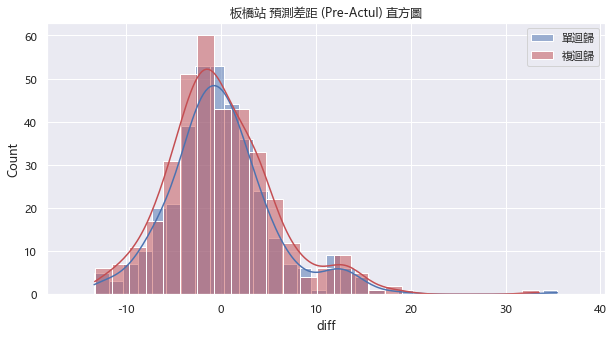

In [25]:
for s in df_result["SiteName"].unique():
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Print outputs
    print(f"\n\n*******{s}*******\n")
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([mutil_reg_diff, single_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

### 參數設定(+CH4)

In [26]:
# 變數設定
X_col_model = ['O3_max',"CH4_max"]
X_col_test = ['O3',"CH4"]
df_pic_for_model = df_pic_5.copy(deep=True)

In [27]:
# 刪除遺漏值
df_result.dropna(how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test, how='any'))}")
df_pic_for_model.dropna(subset=X_col_test, how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 108334


Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'AMB_TEMP', 'CH4', 'NMHC', 'THC', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'CO_max', 'NOx_max', 'NO_max', 'NO2_max', 'SO2_max',
       'AMB_TEMP_max', 'CH4_max', 'NMHC_max', 'THC_max'],
      dtype='object')



*******南投*******

>> X:['O3_max', 'CH4_max']
>> slope:[[0.78443796 0.09827417]]
>> intercept: 0.301
>> r2_score: 0.897

>> Mean Absolute Error: 3.46591392178813
>> Root Mean Squared Error: 4.64781112531357


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 351
>> FP: 1
>> FN: 7
>> TP: 3

>> 預警成功率: 0.3
>> 假警報率: 0.25

>> 預警成功 發布時間點 統計:
時間點   次數
14    3
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 318
>> FP: 1
>> FN: 14
>> TP: 8

>> 預警成功率: 0.364
>> 假警報率: 0.111

>> 預警成功 發布時間點 統計:
時間點   次數
13    3
14    3
15    2
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    3
2.0    3
4.0    1
1.0    1
dtype: int64


*******古亭*******

>> X:['O3_max', 'CH4_max']
>> slope:[[ 0.64785856 -1.06349494]]
>> intercept: 10.405
>> r2_score: 0.82

>> Mean Absolute Error: 5.206432480354414
>> Root Mean Squared Error: 6.578463011406528


*******古亭 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 331
>> FP: 10
>> FN: 12
>> 

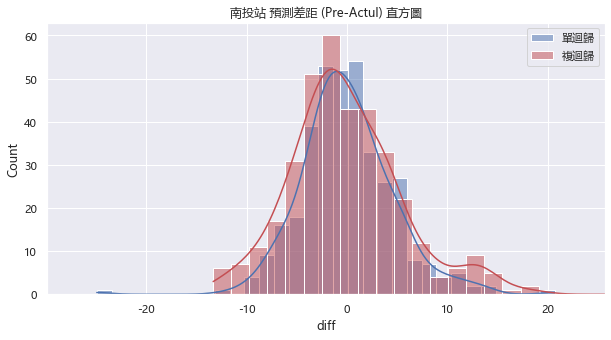

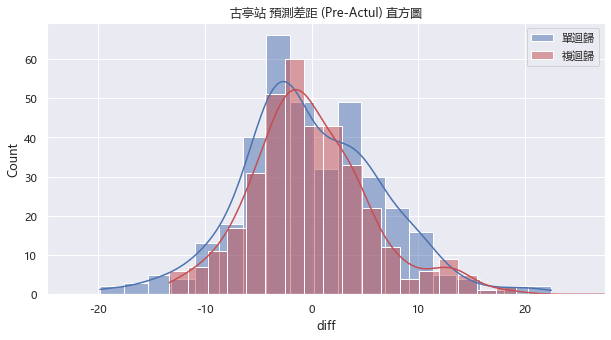

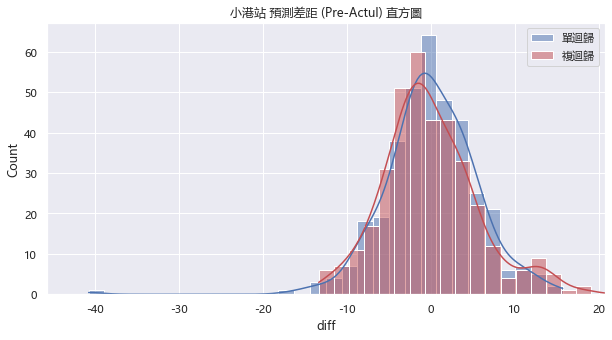

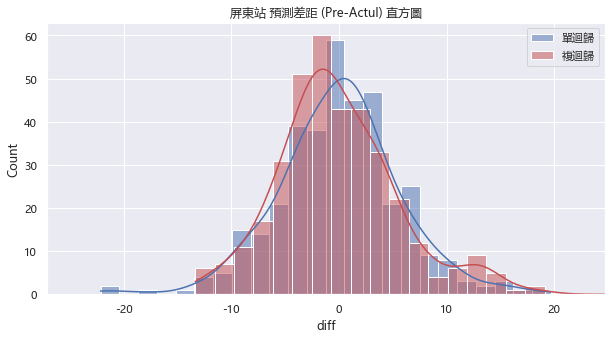

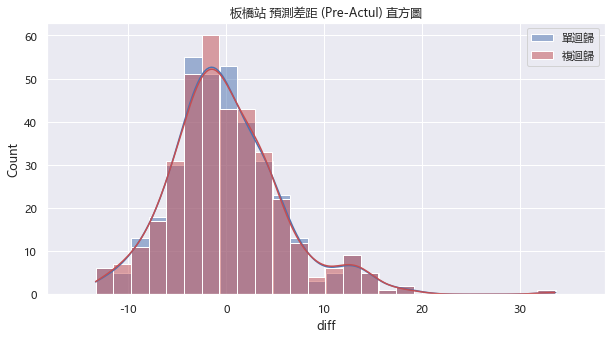

In [28]:
for s in df_result["SiteName"].unique():
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Print outputs
    print(f"\n\n*******{s}*******\n")
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([mutil_reg_diff, single_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

### 參數設定(+溫度、+CH4)

In [29]:
# 變數設定
X_col_model = ['O3_max','AMB_TEMP_max',"CH4_max"]
X_col_test = ['O3','AMB_TEMP',"CH4"]
df_pic_for_model = df_pic_5.copy(deep=True)

In [30]:
# 刪除遺漏值
df_result.dropna(how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test, how='any'))}")
df_pic_for_model.dropna(subset=X_col_test, how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 108341


Index(['index', 'SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2',
       'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'Longitude', 'Latitude', 'SiteId', 'date',
       'AMB_TEMP', 'CH4', 'NMHC', 'THC', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'CO_max', 'NOx_max', 'NO_max', 'NO2_max', 'SO2_max',
       'AMB_TEMP_max', 'CH4_max', 'NMHC_max', 'THC_max'],
      dtype='object')



*******南投*******

>> X:['O3_max', 'AMB_TEMP_max', 'CH4_max']
>> slope:[[0.77606835 0.09924916 0.01595976]]
>> intercept: -2.003
>> r2_score: 0.898

>> Mean Absolute Error: 3.4397719648674503
>> Root Mean Squared Error: 4.62720616883969


*******南投 當年度驗證*******

>>預測目標門檻值: 71

>> TN: 351
>> FP: 1
>> FN: 7
>> TP: 3

>> 預警成功率: 0.3
>> 假警報率: 0.25

>> 預警成功 發布時間點 統計:
時間點   次數
14    3
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
2.0    3
dtype: int64
*******南投 下年度驗證*******

>>預測目標門檻值: 71

>> TN: 318
>> FP: 1
>> FN: 14
>> TP: 8

>> 預警成功率: 0.364
>> 假警報率: 0.111

>> 預警成功 發布時間點 統計:
時間點   次數
13    3
14    2
15    2
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    3
2.0    2
4.0    2
1.0    1
dtype: int64


*******古亭*******

>> X:['O3_max', 'AMB_TEMP_max', 'CH4_max']
>> slope:[[ 0.69237477 -0.36392675 -1.80975092]]
>> intercept: 18.974
>> r2_score: 0.839

>> Mean Absolute Error: 4.716268956327256
>> Root Mean Squared Error: 6.221520351687554


******

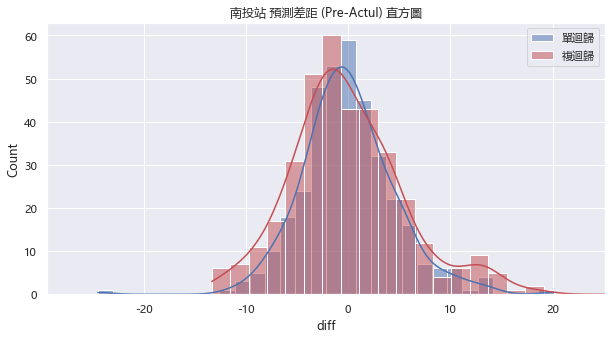

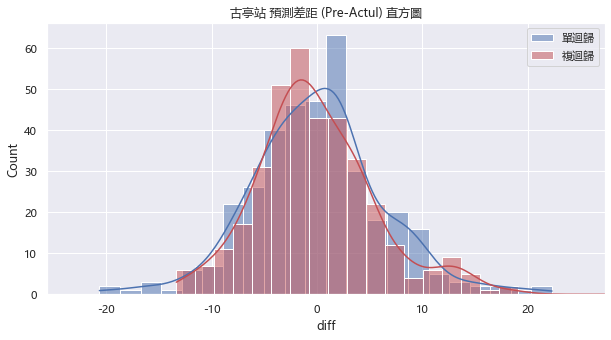

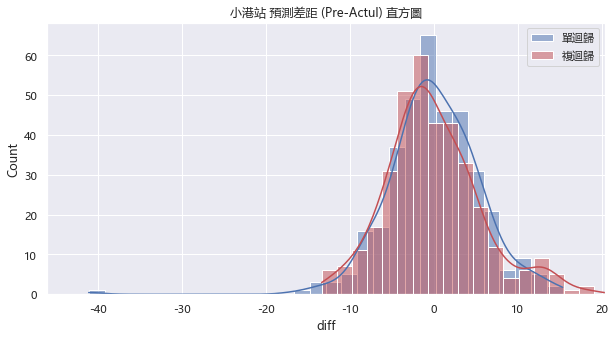

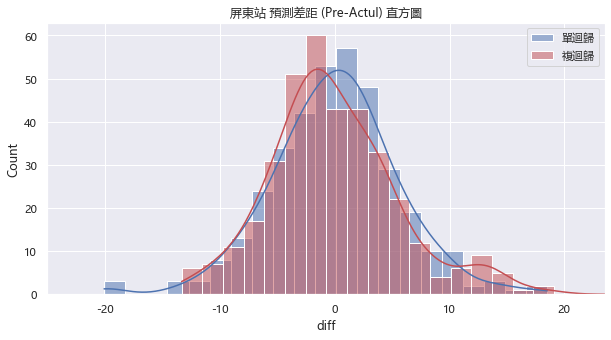

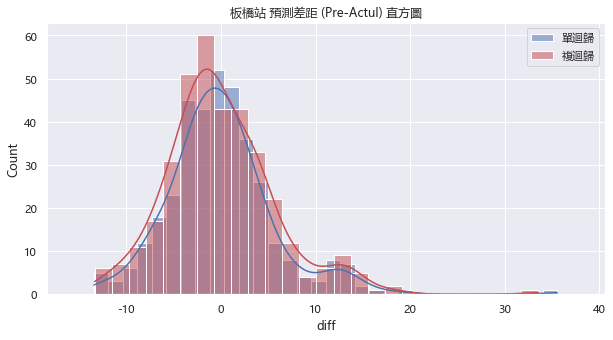

In [31]:
for s in df_result["SiteName"].unique():
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # Print outputs
    print(f"\n\n*******{s}*******\n")
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([mutil_reg_diff, single_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"{s}站 預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print(f"\n")

    # 當年度驗證
    print(f"*******{s} 當年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_self_pred = reg.predict(X_test_self)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
    df_self.loc[:,"y_pred"] = y_test_self_pred
    df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_self = df_self.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

    # 下年度驗證
    print(f"*******{s} 下年度驗證*******\n")

    # 以模型預測每小時資料
    y_test_next_pred = reg.predict(X_test_next)

    # 定義預測超標門檻值
    exceed_value_pred = 71 # 預測超標門檻值

    # 取用小時值資料
    df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
    df_next.loc[:,"y_pred"] = y_test_next_pred
    df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

    # 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
    df_next = df_next.sort_values(
                by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                    ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

    # 驗證對錯>>混淆矩陣
    # metrics.confusion_matrix(y_true, y_pred)
    # (tn, fp, fn, tp)
    cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

    print(f">>預測目標門檻值: {exceed_value_pred}\n")
    print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
    print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

    # 計算 TP  預警時間、提早時數
    mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

    print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
    print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")